<h1>Краткое содержание представленной статьи</h1>

В статье основное внимание уделяется построению системы обнаружения сердечно-сосудистых заболеваний на основе искусственного интеллекта с использованием алгоритмов машинного обучения. 
Наглядно показано, как машинное обучение может помочь предсказать риск развития у человека сердечных заболеваний. 
Представлены инструменты и языки программирования для реализации вышеописанных функций. Стоит отметить, что язык программирования Python интенсивно набирает популярность, но в настоящее время пока не является ведущим. Самыми популярными средствами для работы с медицинскими данными, в настоящий момент, являются Java Script и SQL.
Описаны основные этапы разработки приложений: сбор баз данных, выполнение логистической регрессии и оценку атрибутов набора данных. Описан алгоритм классификатора случайного леса для выявления сердечных заболеваний с более высокой точностью. Стоит отметить, что точность предсказания в 83% является весьма удовлетворительным.


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import torch 
import torch.nn as nn 
from torch.utils.data import random_split, DataLoader, TensorDataset 
import torch.nn.functional as F 
import torch.optim as optim 
from torch.optim import Adam 

import warnings
warnings.filterwarnings('ignore')

from sklearn import linear_model
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn import metrics


<h1> Получен датасет для построения модели машинного обучения: </h1>

In [2]:
train = pd.read_csv('data/train.csv')
display(train)

,ID,age,sex,chest,resting_blood_pressure,serum_cholestoral,fasting_blood_sugar,resting_electrocardiographic_results,maximum_heart_rate_achieved,exercise_induced_angina,oldpeak,slope,number_of_major_vessels,thal,class
0,0,49.207124,0,4.000000,162.996167,181.108682,0,0,148.227858,1,0.944547,2,0,3,1
1,1,53.628425,1,1.741596,130.233730,276.474630,0,2,152.917139,0,0.119070,2,0,3,0
2,2,49.591426,1,4.000000,146.999012,223.300517,1,2,102.352090,1,1.616747,2,2,7,1
3,3,58.991445,1,4.000000,112.369143,187.245501,0,0,158.164750,1,0.000000,1,1,7,1
4,4,51.053602,1,1.954609,138.032047,238.482868,0,0,172.540828,0,1.150464,1,1,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599995,599995,47.832254,1,4.000000,118.418763,300.876566,0,2,161.831133,1,3.151432,2,2,7,1
599996,599996,42.106575,1,3.000000,106.110468,271.719955,0,2,178.749408,1,1.925267,2,0,7,1
599997,599997,41.579352,1,1.295676,128.896878,279.301722,0,0,175.869174,1,0.000000,1,0,7,0
599998,599998,53.716562,1,4.000000,120.061556,276.966278,0,0,171.195150,1,3.007003,2,1,3,1


В датасете предстваленны 13 признаков и принадлежность к классу по риску развития ССЗ:
- age - возраст;
- sex -пол;
- chest - боль в груди (от 1 до 4);
- resting_blood_pressure - Артериальное давление в состоянии покоя;
- serum_cholestoral - Уровень холестерина в крови mg/dl;
- fasting_blood_sugar - Высокий уровень глюкозы крови натощак (> 120 mg/dl);
- resting_electrocardiographic_results - Результаты электрокардиографических исследований в покое (0, 1, 2);
- maximum_heart_rate_achieved - Максимальная ЧСС;
- exercise_induced_angina - Наличие стенокардии при физических нагрузках,
- oldpeak - Депрессия ST-сегмента;
- slope - Наклон пикового сегмента ST при физической нагрузке;
- number_of_major_vessels - количество крупных сосудов (0-3), окрашенных с помощью флюороскопии;
- thal - (3 = норма; 6 = фиксированный дефект; 7 = обратимый дефект);
- class - наличие ССЗ


Общее количество наблюдений: 600 000.

<h3>Первичный анализ данных, обработка аномальных значений:</h3>

In [3]:
train = train.drop(['ID'], axis=1)
train.describe()

,age,sex,chest,resting_blood_pressure,serum_cholestoral,fasting_blood_sugar,resting_electrocardiographic_results,maximum_heart_rate_achieved,exercise_induced_angina,oldpeak,slope,number_of_major_vessels,thal,class
count,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000
mean,54.426085,0.677447,3.170247,131.340485,249.592420,0.150757,1.020148,149.592069,0.333502,1.051391,1.596033,0.681303,4.711378,0.444185
std,9.086041,0.467454,0.949618,17.842450,51.699976,0.357812,0.994204,23.072593,0.471464,1.144288,0.629821,0.950669,1.934766,0.496875
min,26.061695,0.000000,-0.538498,82.918527,98.326263,0.000000,0.000000,61.844168,0.000000,-0.806788,1.000000,0.000000,3.000000,0.000000
25%,48.078493,0.000000,3.000000,119.924094,216.475964,0.000000,0.000000,135.704237,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
50%,55.133425,1.000000,3.000000,129.727941,244.233699,0.000000,2.000000,153.224828,0.000000,0.811101,2.000000,0.000000,3.000000,0.000000
75%,60.663775,1.000000,4.000000,139.915216,274.345453,0.000000,2.000000,165.165497,1.000000,1.674081,2.000000,1.000000,7.000000,1.000000
max,79.591647,1.000000,4.000000,209.673650,527.755764,1.000000,2.000000,208.735196,1.000000,6.803372,3.000000,3.000000,7.000000,1.000000


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600000 entries, 0 to 599999
Data columns (total 14 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   age                                   600000 non-null  float64
 1   sex                                   600000 non-null  int64  
 2   chest                                 600000 non-null  float64
 3   resting_blood_pressure                600000 non-null  float64
 4   serum_cholestoral                     600000 non-null  float64
 5   fasting_blood_sugar                   600000 non-null  int64  
 6   resting_electrocardiographic_results  600000 non-null  int64  
 7   maximum_heart_rate_achieved           600000 non-null  float64
 8   exercise_induced_angina               600000 non-null  int64  
 9   oldpeak                               600000 non-null  float64
 10  slope                                 600000 non-null  int64  
 11  

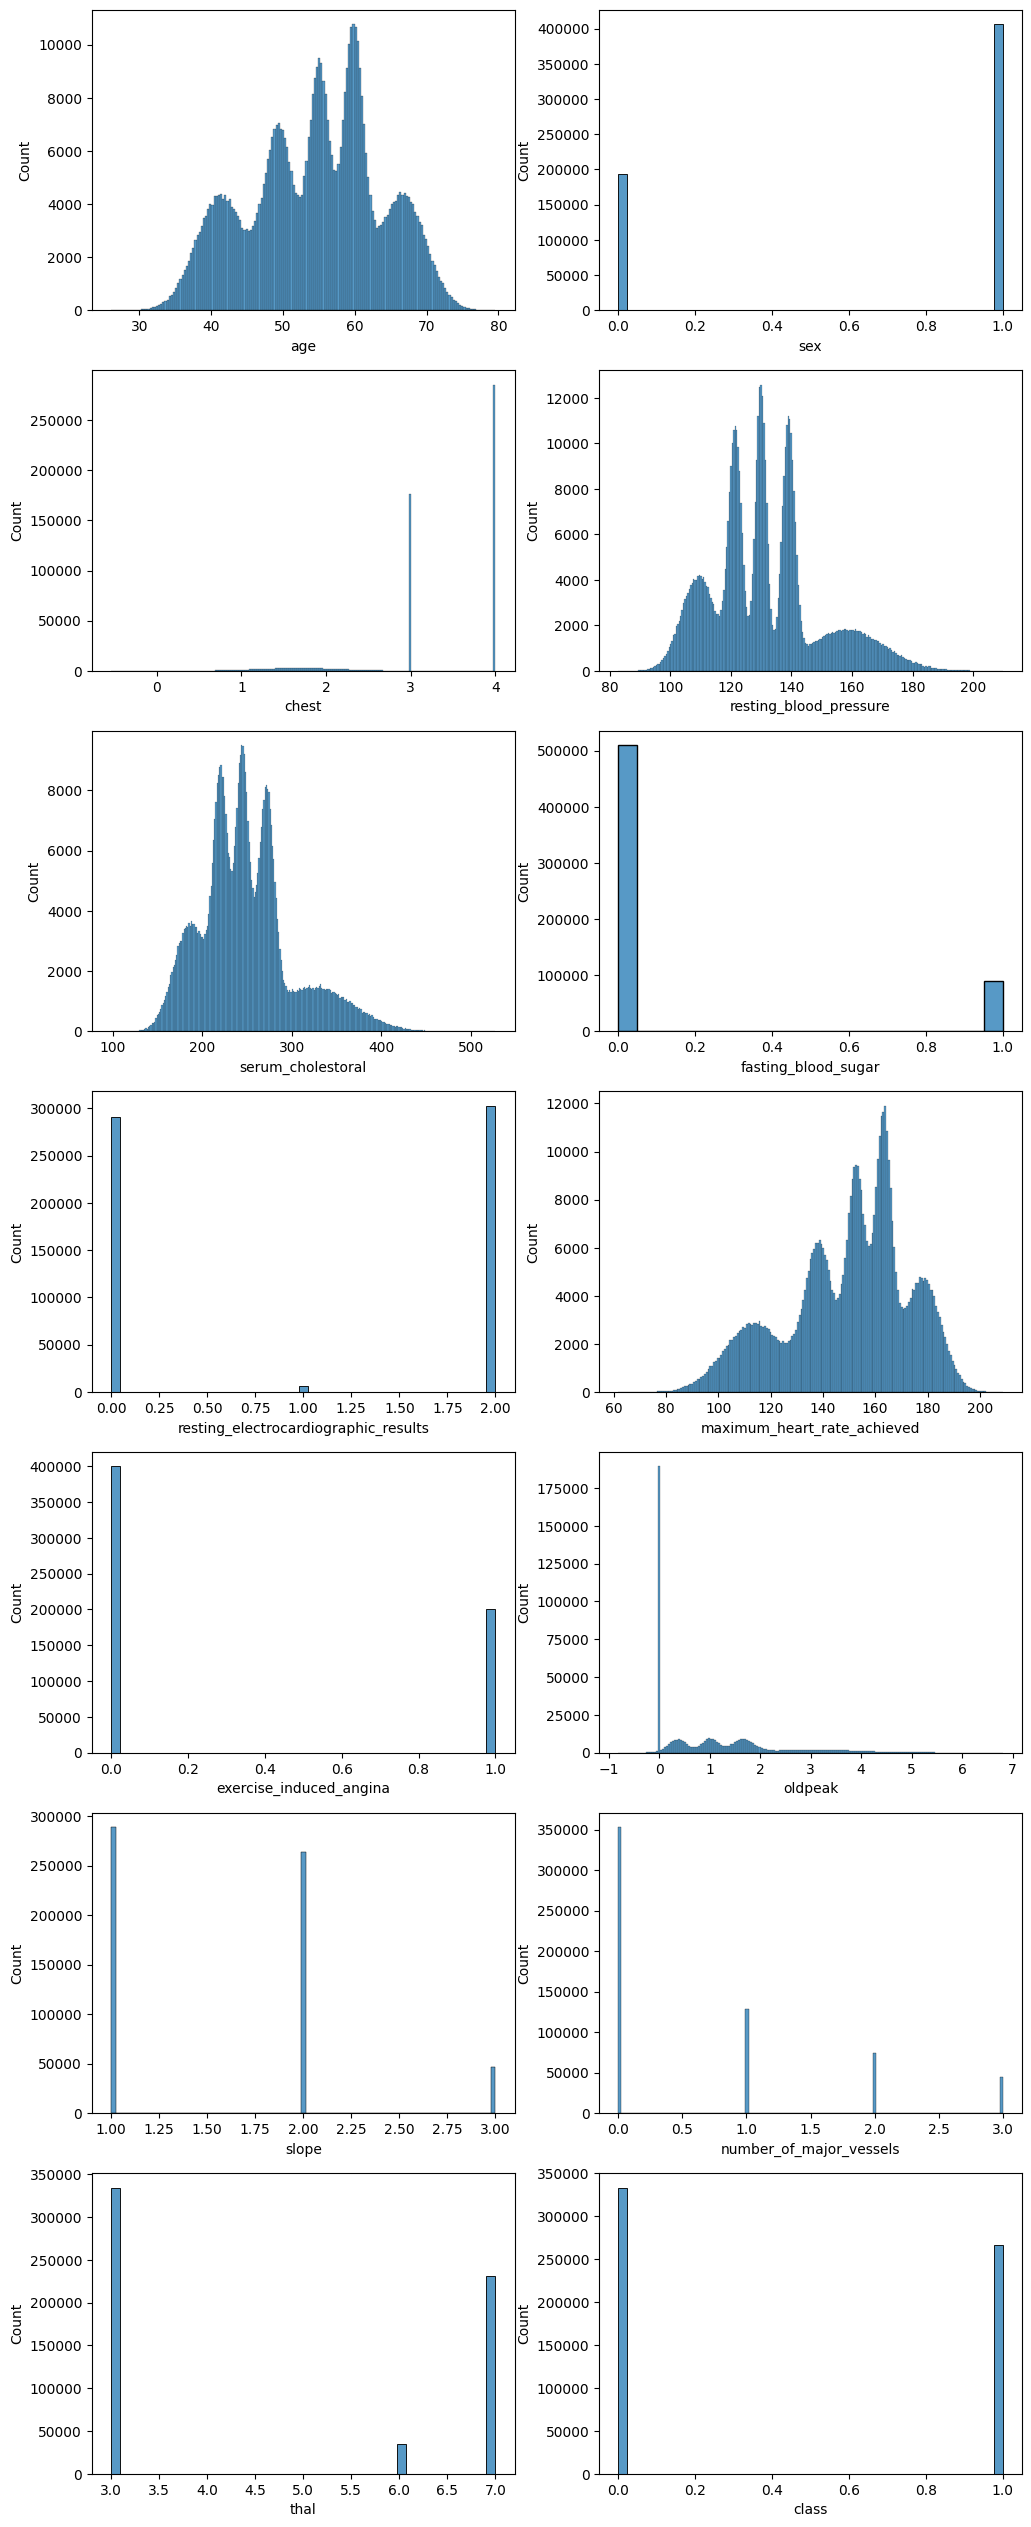

In [5]:
columns = [
    'age',
    'sex',
    'chest',
    'resting_blood_pressure',
    'serum_cholestoral',
    'fasting_blood_sugar',
    'resting_electrocardiographic_results',
    'maximum_heart_rate_achieved',
    'exercise_induced_angina',
    'oldpeak',
    'slope',
    'number_of_major_vessels',
    'thal',
    'class'
    ]

# Создадим диаграммы, по всем параметрам, для определения распределений и наличий аномальных значений
fig, ax = plt.subplots(nrows=7, ncols=2, figsize=(12, 32))
ax = ax.flatten()
for i in columns:
    sns.histplot(train[i],
                ax = ax[columns.index(i)])


Анамальные значения имеются в столбцах:
- chest - имеются промежуточные значения
- oldpeak - имеются отрицательные значения 

In [6]:
train_cleaned = train.copy()

# Зададим функции для удаления анномальных значений:

def chest_to(chest):
    if chest <1.49:
        return 1
    elif 1.5 <= chest <= 2.49:
        return 2
    elif 2.5 <= chest <= 3.49:
        return 3
    elif 3.5 <= chest:
        return 4
    else:
        return chest

def oldpeak_to(oldpeak):
    if oldpeak <0:
        return 0.000000
    else:
        return oldpeak

# Применим вышеуказанные функции
train_cleaned['chest'] = train_cleaned['chest'].apply(chest_to)
train_cleaned['oldpeak'] = train_cleaned['oldpeak'].apply(oldpeak_to)

# Проверка датасета на наличие дубликатов
train_cleaned = train_cleaned.drop_duplicates()

train_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600000 entries, 0 to 599999
Data columns (total 14 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   age                                   600000 non-null  float64
 1   sex                                   600000 non-null  int64  
 2   chest                                 600000 non-null  float64
 3   resting_blood_pressure                600000 non-null  float64
 4   serum_cholestoral                     600000 non-null  float64
 5   fasting_blood_sugar                   600000 non-null  int64  
 6   resting_electrocardiographic_results  600000 non-null  int64  
 7   maximum_heart_rate_achieved           600000 non-null  float64
 8   exercise_induced_angina               600000 non-null  int64  
 9   oldpeak                               600000 non-null  float64
 10  slope                                 600000 non-null  int64  
 11  

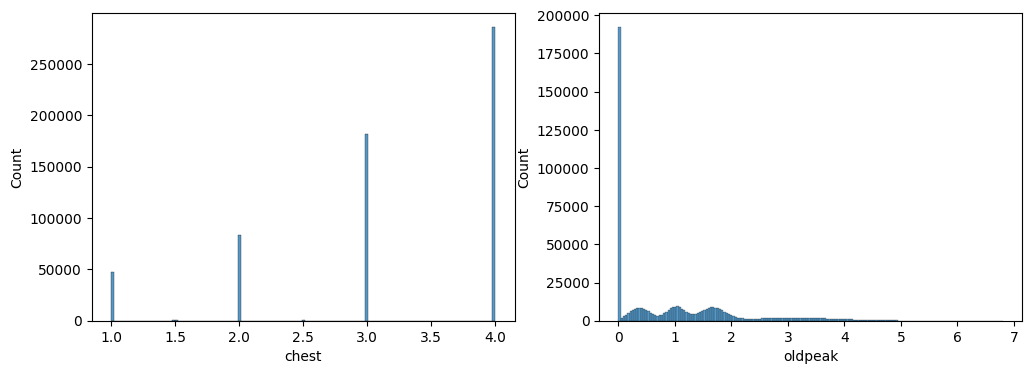

In [7]:
# Повторное построение диаграмм, после коррекции аномальных значений
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
sns.histplot(train_cleaned['chest'], ax = ax[0])
sns.histplot(train_cleaned['oldpeak'], ax = ax[1])
plt.show()

<h3>Проведение корреляционного анализа</h3>

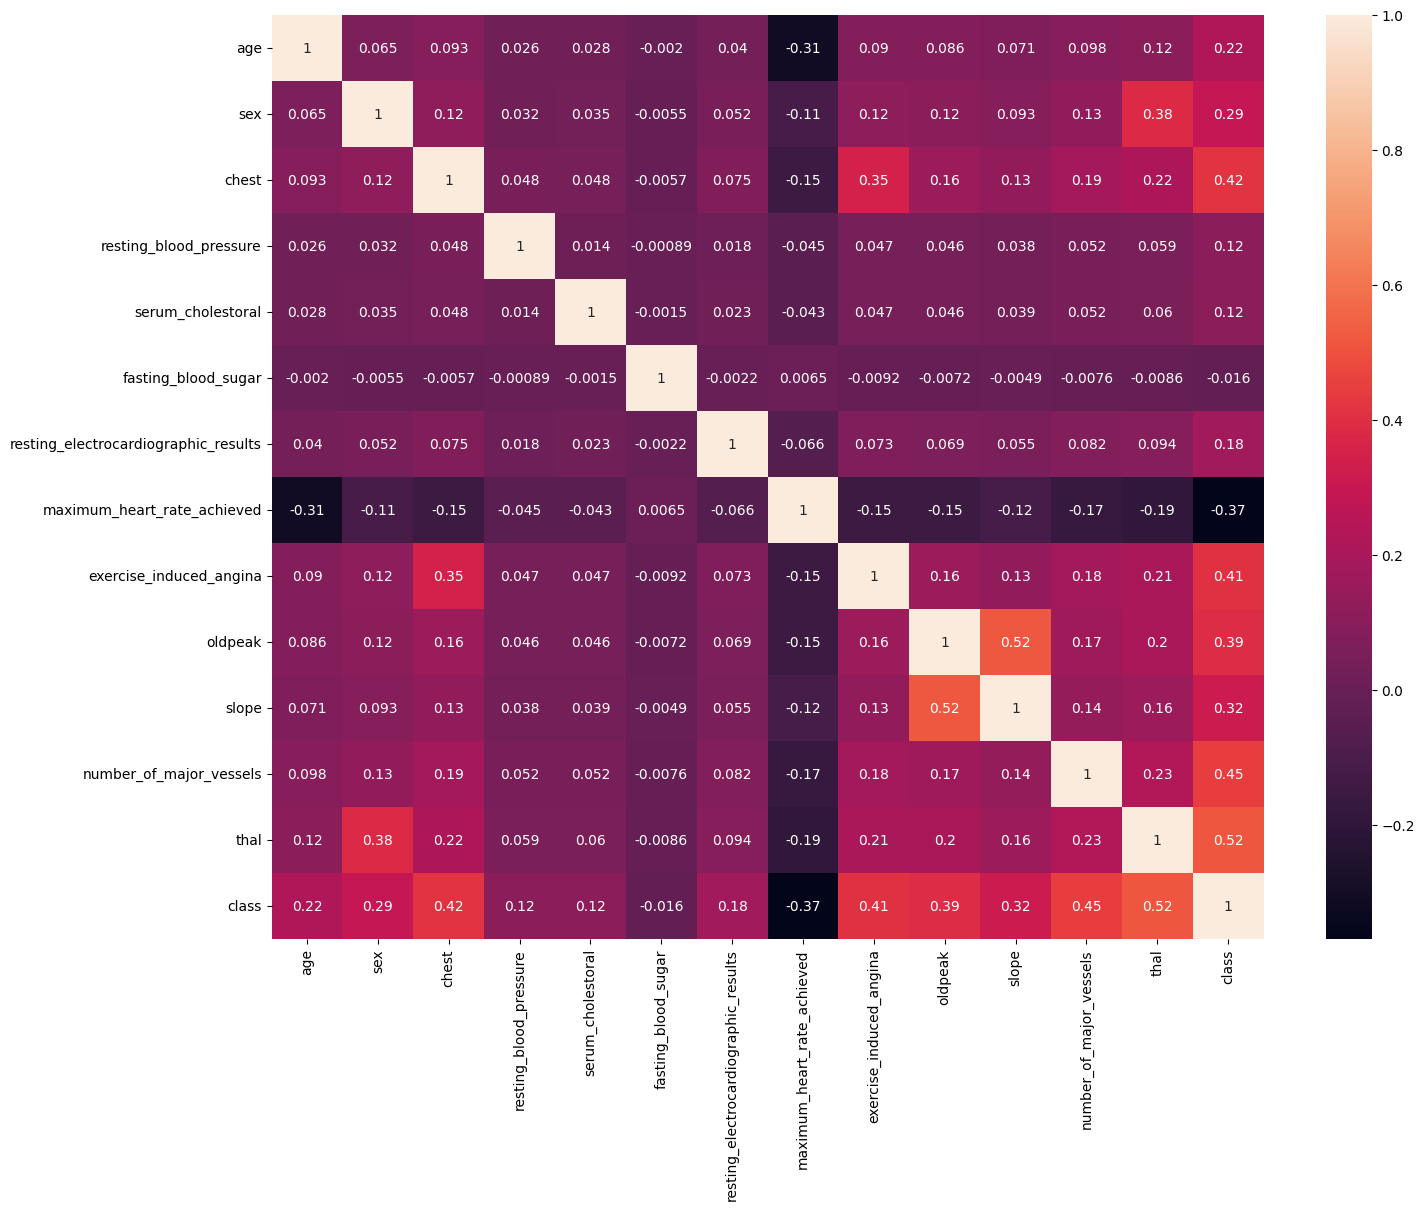

In [8]:
# Построение Heatmap корреляционной матрицы:
fig, ax = plt.subplots(figsize = (16, 12))
sns.heatmap(train_cleaned.corr(), annot=True)
plt.show()

Показатели пригодные для постороения модели обучения:
- chest (индекс 0,42)
- maximum_heart_rate_achieved (индекс - 0,37)
- exercise_induced_angina (индекс 0,41)
- oldpeak (индекс 0,39)
- slope (индекс 0,32)
- number_of_major_vessels (индекс 0,45)
- thal (индекс 0,52)

In [9]:
# Создадим список, пригодных для посроения модели, столбцов:
applicable_columns = [
    'chest',
    'maximum_heart_rate_achieved',
    'exercise_induced_angina',
    'oldpeak',
    'slope',
    'number_of_major_vessels',
    'thal'
    ]

<h3> Обработка выбросов </h3>

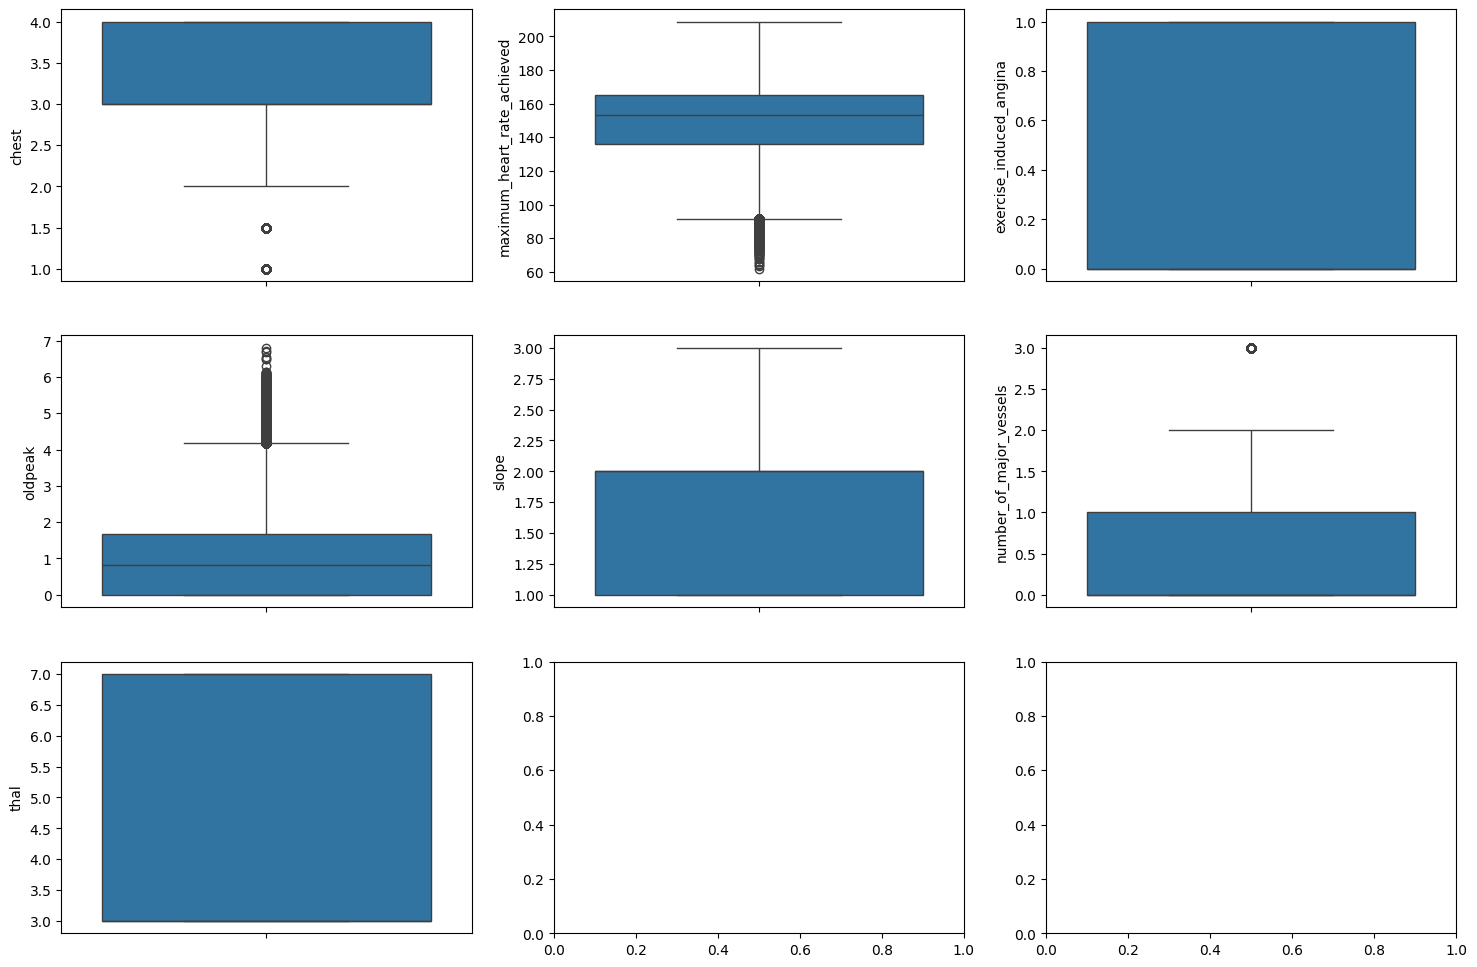

In [137]:
# Построим коробчатые диаграммы:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(18, 12))
ax = ax.flatten()
for i in applicable_columns:
    sns.boxplot(train_cleaned[i],
                ax = ax[applicable_columns.index(i)])

Существенные выбросы имеются в показателях:
- oldpeak
- maximum_heart_rate_achieved

Не значительные выбросы:
- chest
- number_of_major_vessels

In [142]:
train_treated = train_cleaned.copy()

# Функция бля обработки выбросов по Q1
def treat_Q1(meaning):
    factor = 1.5
    q1 = np.percentile(meaning, 25)
    q3 = np.percentile(meaning, 75)
    iqr = q3 - q1
    lower_bound = q1 - (iqr * factor)
    upper_bound = q3 + (iqr * factor)
    treated_data = meaning.copy()
    treated_data[(meaning < lower_bound) | (meaning > upper_bound)] = q1
    return treated_data

# Функция бля обработки выбросов по Q3
def treat_Q3(meaning):
    factor = 1.5
    q1 = np.percentile(meaning, 25)
    q3 = np.percentile(meaning, 75)
    iqr = q3 - q1
    lower_bound = q1 - (iqr * factor)
    upper_bound = q3 + (iqr * factor)
    treated_data = meaning.copy()
    treated_data[(meaning < lower_bound) | (meaning > upper_bound)] = q3
    return treated_data

# Применим вышеописанные функции
train_treated['maximum_heart_rate_achieved'] = treat_Q1(train_treated['maximum_heart_rate_achieved'])
train_treated['chest'] = treat_Q1(train_treated['chest'])
train_treated['oldpeak'] = treat_Q3(train_treated['oldpeak'])
train_treated['number_of_major_vessels'] = treat_Q3(train_treated['number_of_major_vessels'])

train_treated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600000 entries, 0 to 599999
Data columns (total 14 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   age                                   600000 non-null  float64
 1   sex                                   600000 non-null  int64  
 2   chest                                 600000 non-null  float64
 3   resting_blood_pressure                600000 non-null  float64
 4   serum_cholestoral                     600000 non-null  float64
 5   fasting_blood_sugar                   600000 non-null  int64  
 6   resting_electrocardiographic_results  600000 non-null  int64  
 7   maximum_heart_rate_achieved           600000 non-null  float64
 8   exercise_induced_angina               600000 non-null  int64  
 9   oldpeak                               600000 non-null  float64
 10  slope                                 600000 non-null  int64  
 11  

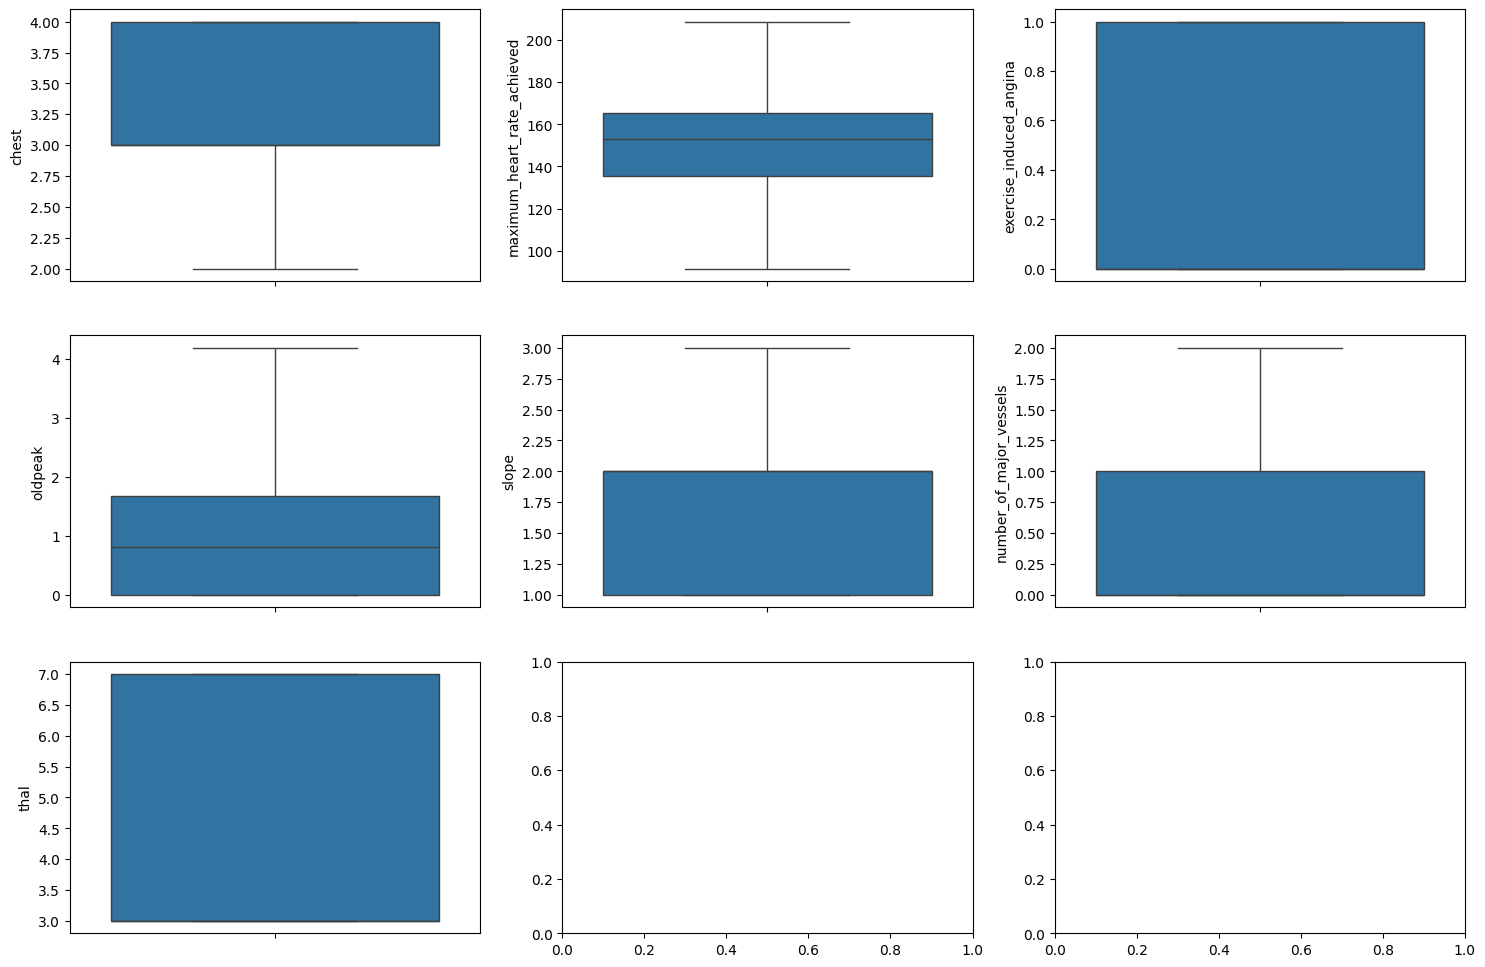

In [153]:
# Контрольные коробчатые диаграммы:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(18, 12))
ax = ax.flatten()
for i in applicable_columns:
    sns.boxplot(train_treated[i],
                ax = ax[applicable_columns.index(i)])
plt.show()

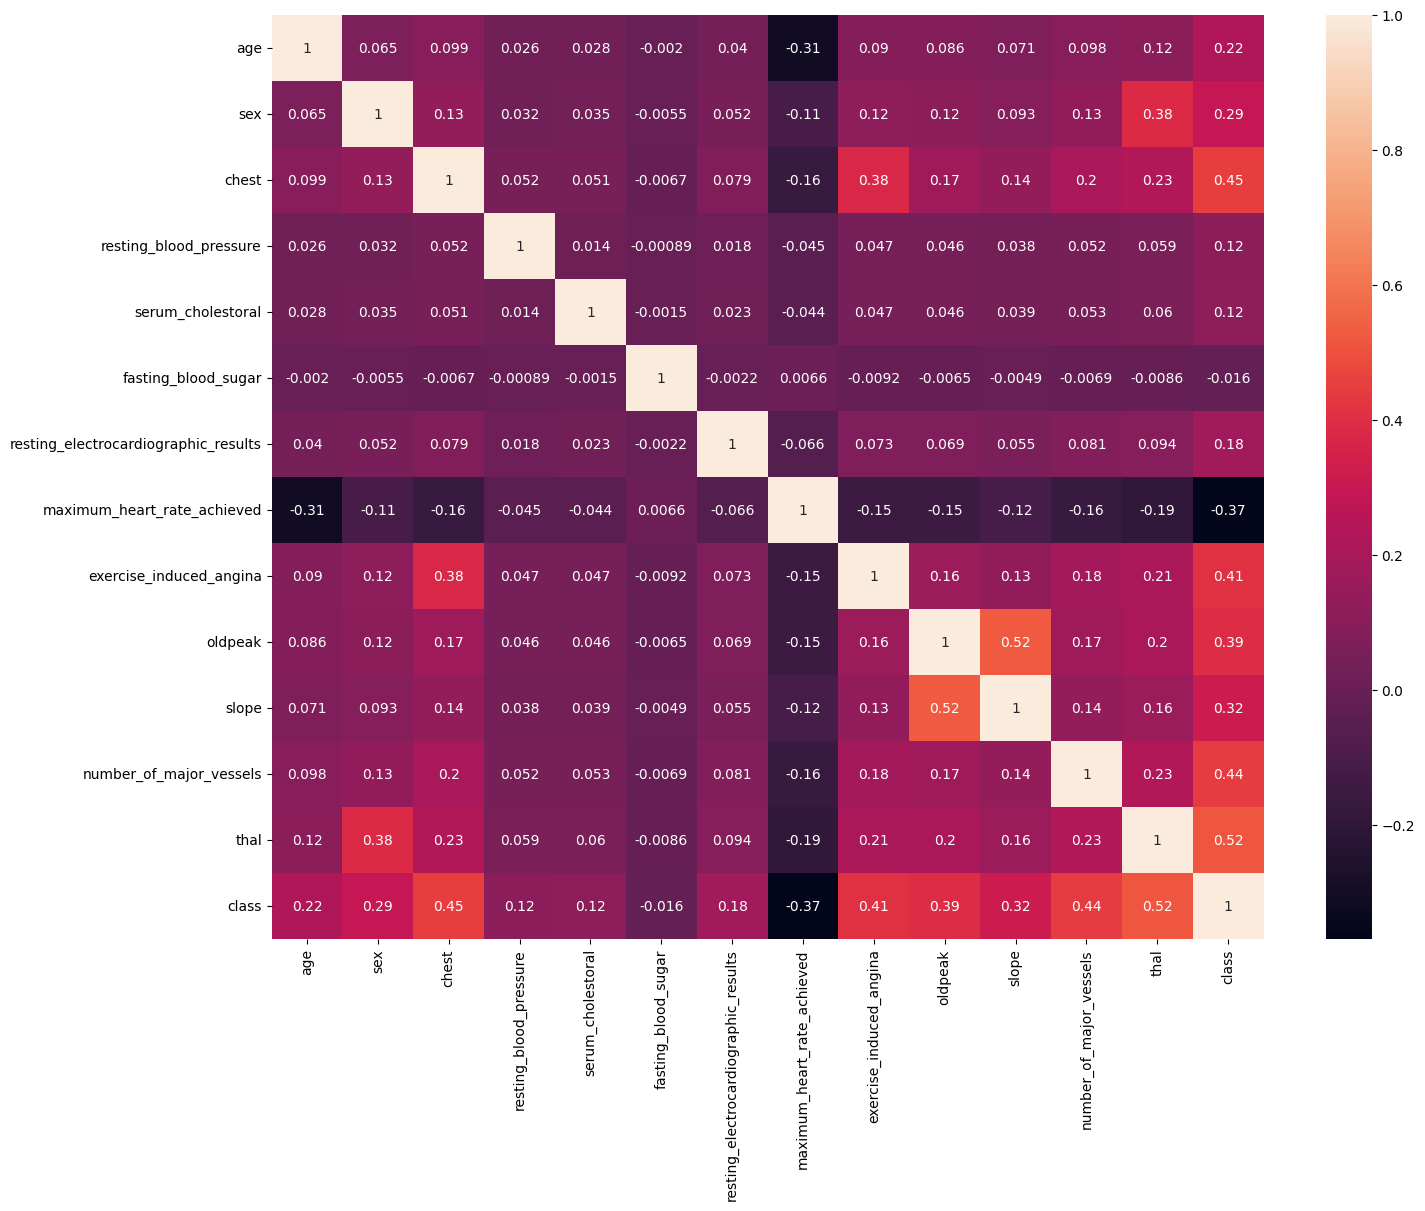

In [146]:
# Повторное построение Heatmap корреляционной матрицы:
fig, ax = plt.subplots(figsize = (16, 12))
sns.heatmap(train_treated.corr(), annot=True)
plt.show()

Построим диаграммы рассеяния по двум параметрам:

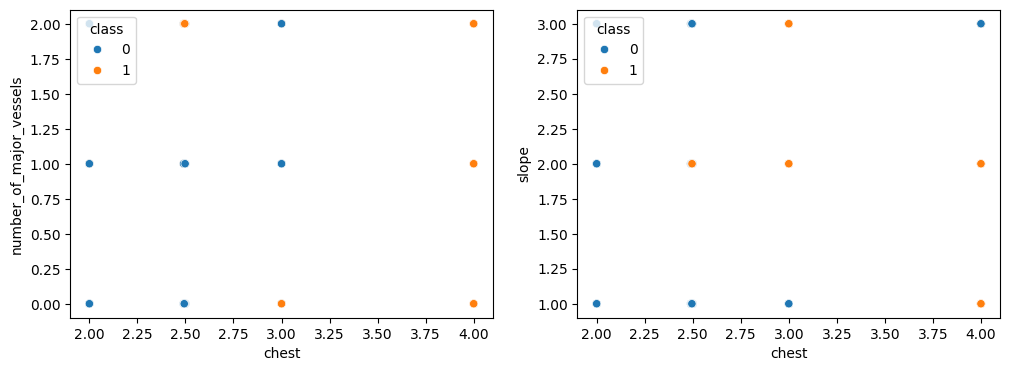

In [147]:
factors_for_chest = [
    'number_of_major_vessels',
    'slope'
    ]
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
ax = ax.flatten()
for i in factors_for_chest:
    sns.scatterplot(data=train_treated,
    x='chest', y=i, hue='class',
    ax = ax[factors_for_chest.index(i)]);

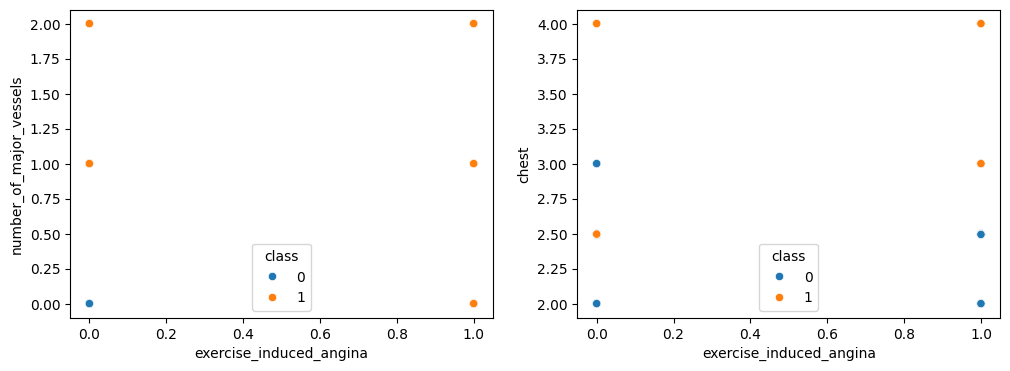

In [148]:
factors_for_exercise_induced_angina = [
    'number_of_major_vessels',
    'chest'
    ]
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
ax = ax.flatten()
for i in factors_for_exercise_induced_angina:
    sns.scatterplot(data=train_treated,
    x='exercise_induced_angina', y=i, hue='class',
    ax = ax[factors_for_exercise_induced_angina.index(i)]);

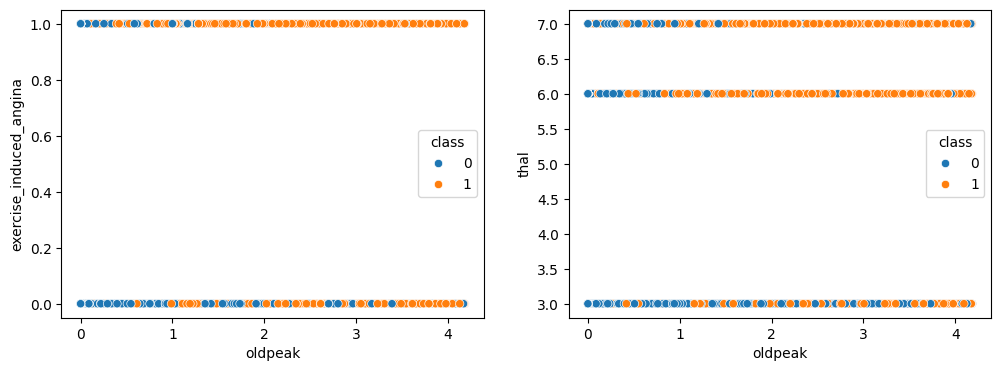

In [149]:
factors_for_oldpeak = [
    'exercise_induced_angina',
    'thal'
    ]
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
ax = ax.flatten()
for i in factors_for_oldpeak:
    sns.scatterplot(data=train_treated,
    x='oldpeak', y=i, hue='class',
    ax = ax[factors_for_oldpeak.index(i)]);

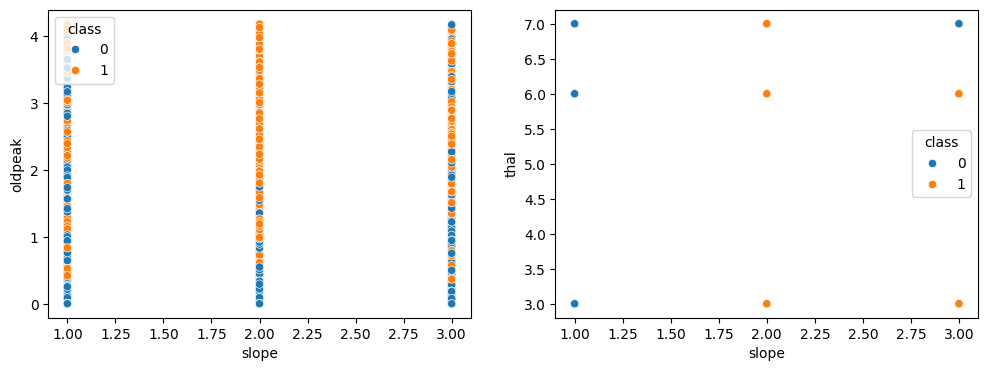

In [150]:
factors_for_slope = [
    'oldpeak',
    'thal'
    ]
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
ax = ax.flatten()
for i in factors_for_slope:
    sns.scatterplot(data=train_treated,
    x='slope', y=i, hue='class',
    ax = ax[factors_for_slope.index(i)]);

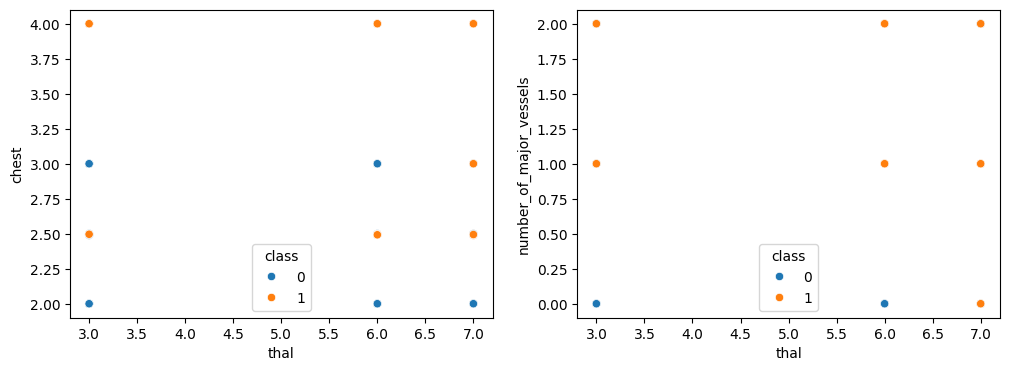

In [151]:
factors_for_thal = [
    'chest',
    'number_of_major_vessels'
    ]
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
ax = ax.flatten()
for i in factors_for_thal:
    sns.scatterplot(data=train_treated,
    x='thal', y=i, hue='class',
    ax = ax[factors_for_thal.index(i)]);
    


На диаграммах рассеяния, наиболее связанными можно отметить пары:
- namber_of_major_vessels + exercise_induced_angina
- oldpeak + exercise_induced_angina
- oldpeak + thal
- thal + nuamber_of_major_vessels

<h1>Построение моделей машинного обучения</h1>

In [154]:
test = pd.read_csv('data/test.csv')
sample_submission = pd.read_csv('data/sample_submission.csv')

X_test = test[applicable_columns]
y_test = sample_submission['class']
#display(X_test)
#display(y_test)

<h2>Logistic Regression</h2>

In [155]:
X_log_reg = train_treated[applicable_columns]
y_log_reg = train_treated['class']

X_log_reg.head()

,chest,maximum_heart_rate_achieved,exercise_induced_angina,oldpeak,slope,number_of_major_vessels,thal
0,4.0,148.227858,1,0.944547,2,0,3
1,2.0,152.917139,0,0.119070,2,0,3
2,4.0,102.352090,1,1.616747,2,2,7
3,4.0,158.164750,1,0.000000,1,1,7
4,2.0,172.540828,0,1.150464,1,1,3


In [156]:
#Создаём объект класса LogisticRegression 
log_reg = linear_model.LogisticRegression(
    multi_class='multinomial', #мультиклассовая классификация
    max_iter=1000, #количество итераций, выделенных на сходимость
    random_state=42 #генерация случайных чисел
)
#Обучаем модель 
log_reg.fit(X_log_reg, y_log_reg)

LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=42)

In [157]:
#Делаем предсказание вероятностей
y_pred_proba = np.round(log_reg.predict_proba(X_log_reg), 2)
#Делаем предсказание класса
y_pred_log_reg = log_reg.predict(X_log_reg)

print(metrics.classification_report(y_log_reg, y_pred_log_reg))

              precision    recall  f1-score   support

           0       0.88      0.89      0.89    333489
           1       0.86      0.84      0.85    266511

    accuracy                           0.87    600000
   macro avg       0.87      0.87      0.87    600000
weighted avg       0.87      0.87      0.87    600000



In [158]:
y_pred_test = log_reg.predict(X_test)

print(metrics.classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       1.00      0.56      0.72    400000
           1       0.00      0.00      0.00         0

    accuracy                           0.56    400000
   macro avg       0.50      0.28      0.36    400000
weighted avg       1.00      0.56      0.72    400000



<h3>Random Forest Classifier</h3>

In [159]:
X_rfc = train_treated[applicable_columns]
y_rfc = train_treated['class']

# Разделение данных на обучающую и тестовую выборки
X_train_rfc, X_test_rfc, y_train_rfc, y_test_rfc = train_test_split(X_rfc, y_rfc, test_size=0.3, random_state=42)

In [160]:
# Создание модели
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Обучение модели
rf_classifier.fit(X_train_rfc, y_train_rfc)

RandomForestClassifier(random_state=42)

In [161]:
# Предсказания на тренеровочной выборке
y_pred_rfc = rf_classifier.predict(X_test_rfc)

# Оценка точности модели
accuracy = accuracy_score(y_test_rfc, y_pred_rfc)
print(f"Точность модели на тренировочных данных: {accuracy:.2f}")

Точность модели на тренировочных данных: 0.86


In [162]:
# Предсказания на тестовой выборке
y_pred_rfc = rf_classifier.predict(X_test)

# Оценка точности модели
accuracy = accuracy_score(y_test, y_pred_rfc)
print(f"Точность модели на тестовых данных: {accuracy:.2f}")

Точность модели на тестовых данных: 0.56


<h3>Neural Network on PyTorch</h3>


Подготовка данных:

In [163]:
input = train_treated[applicable_columns]           
output = train_treated['class']

In [164]:
# Преобразуем входные и выходные данные в тензоры и создадим TensorDataset 
input = torch.Tensor(input.to_numpy())      
print('\nInput format: ', input.shape, input.dtype)    
output = torch.tensor(output.to_numpy())       
print('Output format: ', output.shape, output.dtype)
data = TensorDataset(input, output)


Input format:  torch.Size([600000, 7]) torch.float32
Output format:  torch.Size([600000]) torch.int64


In [165]:

# Разделение наборов для обучения, проверки и тестирования с использованием случайного сплита
train_batch_size = 10        
number_rows = len(input)    # Количество строк в таблице 
test_split = int(number_rows*0.3)   # Набор данных для тестирования  
validate_split = int(number_rows*0.2)   # Набор данных для проверки
train_split = number_rows - test_split - validate_split     # Набор данных для обучения
train_set, validate_set, test_set = random_split(data, [train_split, validate_split, test_split])    
 
# Создаем Dataloader, чтобы считывать данные в пакетном режиме и помещать их в память
train_loader = DataLoader(train_set, batch_size = train_batch_size, shuffle = True) 
validate_loader = DataLoader(validate_set, batch_size = 1) 
test_loader = DataLoader(test_set, batch_size = 1)

In [167]:
# Определяем параметры модели
input_size = list(input.shape)[1]   # Определяем количество признаков
learning_rate = 0.01 
output_size = 2


# Конструктор
class Network(nn.Module): 
   def __init__(self, input_size, output_size): 
       super(Network, self).__init__() 
        
       self.layer1 = nn.Linear(input_size, 24) 
       self.layer2 = nn.Linear(24, 24) 
       self.layer3 = nn.Linear(24, output_size) 


   def forward(self, x): 
       x1 = F.relu(self.layer1(x)) 
       x2 = F.relu(self.layer2(x1)) 
       x3 = self.layer3(x2) 
       return x3 
 
# Создание модели
model = Network(input_size, output_size) 

In [168]:
# Определяем устройство выполнения:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
print("The model will be running on", device, "device\n") 
# Преобразование параметров модели и буферов в CPU или Cuda
model.to(device)

The model will be running on cpu device



Network(
  (layer1): Linear(in_features=7, out_features=24, bias=True)
  (layer2): Linear(in_features=24, out_features=24, bias=True)
  (layer3): Linear(in_features=24, out_features=2, bias=True)
)

In [169]:
# Определяем функцию для сохранени модели
def saveModel(): 
    path = "./NetModel.pth" 
    torch.save(model.state_dict(), path)

In [170]:
# Определяем функцию потерь с помощью оптимизатора Adam
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

In [171]:
# Определим функцию для обучениния
def train(num_epochs): 
    best_accuracy = 0.0 
     
    print("Begin training...") 
    for epoch in range(1, num_epochs+1): 
        running_train_loss = 0.0 
        running_accuracy = 0.0 
        running_vall_loss = 0.0 
        total = 0 
 
        # Задаем тренеровочный цикл
        for data in train_loader: 
        #for data in enumerate(train_loader, 0): 
            inputs, outputs = data 
            optimizer.zero_grad()           
            predicted_outputs = model(inputs)  
            train_loss = loss_fn(predicted_outputs, outputs)
            train_loss.backward() 
            optimizer.step()       
            running_train_loss +=train_loss.item()
 
        # Расчет потерь при обучении
        train_loss_value = running_train_loss/len(train_loader) 
 
        # Визуализация обучения
        with torch.no_grad(): 
            model.eval() 
            for data in validate_loader: 
               inputs, outputs = data 
               predicted_outputs = model(inputs) 
               val_loss = loss_fn(predicted_outputs, outputs)
               
               _, predicted = torch.max(predicted_outputs, 1) 
               running_vall_loss += val_loss.item()  
               total += outputs.size(0) 
               running_accuracy += (predicted == outputs).sum().item() 
               
        # Рассчитать объема потерь при проверке
        val_loss_value = running_vall_loss/len(validate_loader) 
                
        # Расчет правильности прогнозов в % отношении 
        accuracy = (100 * running_accuracy / total)     
 
        # Сохранение модели
        if accuracy > best_accuracy: 
            saveModel() 
            best_accuracy = accuracy 
         
        # Выведедение статистики по эпохам
        print('Completed training batch', epoch, 'Training Loss is: %.4f' %train_loss_value, 'Validation Loss is: %.4f' %val_loss_value, 'Accuracy is %d %%' % (accuracy))

In [172]:
# определим функции для тестирования модели
def test(): 
    model = Network(input_size, output_size) 
    path = "NetModel.pth" 
    model.load_state_dict(torch.load(path)) 
     
    running_accuracy = 0 
    total = 0 
 
    with torch.no_grad(): 
        for data in test_loader: 
            inputs, outputs = data 
            outputs = outputs.to(torch.float32) 
            predicted_outputs = model(inputs) 
            _, predicted = torch.max(predicted_outputs, 1) 
            total += outputs.size(0) 
            running_accuracy += (predicted == outputs).sum().item() 
 
        print('Accuracy of the model based on the test set of', test_split ,'inputs is: %d %%' % (100 * running_accuracy / total))    
 
def test_species(): 
    model = Network(input_size, output_size) 
    path = "NetModel.pth" 
    model.load_state_dict(torch.load(path)) 
     
    labels_length = 2 
    labels_correct = list(0. for i in range(labels_length))
    labels_total = list(0. for i in range(labels_length))
  
    with torch.no_grad(): 
        for data in test_loader: 
            inputs, outputs = data 
            predicted_outputs = model(inputs) 
            _, predicted = torch.max(predicted_outputs, 1) 
             
            label_correct_running = (predicted == outputs).squeeze() 
            label = outputs[0] 
            if label_correct_running.item():  
                labels_correct[label] += 1 
            labels_total[label] += 1  
  
    label_list = [0,1]
    for i in range(output_size): 
        print('Accuracy to predict %5s : %2d %%' % (label_list[i], 100 * labels_correct[i] / labels_total[i]))

In [173]:
# Запуск обучения нейронной сети
if __name__ == "__main__": 
    num_epochs = 10
    train(num_epochs) 
    print('Finished Training\n') 
    test() 
    test_species()

Begin training...
Completed training batch 1 Training Loss is: 0.3214 Validation Loss is: 0.3245 Accuracy is 86 %
Completed training batch 2 Training Loss is: 0.3072 Validation Loss is: 0.3000 Accuracy is 87 %
Completed training batch 3 Training Loss is: 0.3042 Validation Loss is: 0.2984 Accuracy is 87 %
Completed training batch 4 Training Loss is: 0.3020 Validation Loss is: 0.2964 Accuracy is 87 %
Completed training batch 5 Training Loss is: 0.3005 Validation Loss is: 0.2965 Accuracy is 87 %
Completed training batch 6 Training Loss is: 0.2983 Validation Loss is: 0.3049 Accuracy is 87 %
Completed training batch 7 Training Loss is: 0.2965 Validation Loss is: 0.2924 Accuracy is 87 %
Completed training batch 8 Training Loss is: 0.2951 Validation Loss is: 0.3271 Accuracy is 86 %
Completed training batch 9 Training Loss is: 0.2942 Validation Loss is: 0.2902 Accuracy is 87 %
Completed training batch 10 Training Loss is: 0.2939 Validation Loss is: 0.2903 Accuracy is 87 %
Finished Training

Ac